# Grid search example

This is a grid search example, modified the default Bollinger bands example.

- Set up searchable strategy parameter and then generate a matrix of all possible combinations of these for a grid search

- Perform parallel run to multiple backtests at the same time using a thread pool

- Compare results

For more details, see README.

### Github notebook rendering issues

**If you are viewing this file on Github**: The current Github online notebook viewer cannot render the interactive Plotly charts used in this notebook.
To view the charts, you need to download run the notebook locally.

## Set up

Set up the parameters used in in this strategy backtest study.

- Unlike in a fixed parameter strategy study, we define some of the strategy parameters as list of options
- We later createa a grid search matrix which will go through all the combinations of these options

In [1]:
import datetime

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency

#
# Strategy properties
# 

STRATEGY_NAME = "Bollinger bands example"

# How our trades are routed.
TRADE_ROUTING = TradeRouting.trader_joe_usdc

# How often the strategy performs the decide_trades cycle.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_4h

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h4

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m15

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Which trading pair we are backtesting on
# (Might be different from the live trading pair)
# https://tradingstrategy.ai/trading-view/polygon/quickswap/eth-usdc
TRADING_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDC")

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.50

# Start with this amount of USD
INITIAL_DEPOSIT = 5_000

#
# Strategy inputs
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 90

# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

#
# Grid searched parameters
#

# Bollinger band's standard deviation options
#
STDDEV = [1.0, 1.5, 1.7, 2.0]

# RSI must be above this value to open a new position.
RSI_THRESHOLD = [55, 65, 75, 85]

# What's the moving average length in candles for Bollinger bands
MOVING_AVERAGE_LENGTH = [7, 14, 20]

# Backtest range
#
# Note that for this example notebook we deliberately choose a very short period,
# as the backtest completes faster, charts are more readable
# and tables shorter for the demostration.
#
START_AT = datetime.datetime(2022, 3, 1)

# Backtest range
END_AT = datetime.datetime(2022, 10, 1)

# Stop loss relative to the mid price during the time when the position is opened
#
# If the price drops below this level, trigger a stop loss
STOP_LOSS_PCT = 0.98


## Strategy logic and trade decisions

- `decide_trades()` function decide what trades to take.
- As this is a grid search example, we nest `decide_trades()` within `grid_search_worker()`.
- `grid_search_worker()` is responsible for getting the combination inputs from the grid search manager
  and then setting up `decide_trades()` with its dynamic parameters.
- We do not plot any visualisations like upper and lower band like we do in individual strategy analysis;
  plotting takes time and this information is not relevant for grid search analysis in this point.

***Note**: We have lowercased the grid searched parameter names here. In most programming languages,
uppercased variables are constant and lowercased dynamic. Because grid searcher parameters are now dynamic,
we use snake case to notate them to differ them from constants.

In [2]:
from typing import List, Dict

import pandas as pd
from pandas_ta import bbands
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe

from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.backtest.grid_search import GridCombination, GridSearchResult
from tradeexecutor.backtest.grid_search import run_grid_search_backtest
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def grid_search_worker(
        universe: TradingStrategyUniverse,
        combination: GridCombination,
) -> GridSearchResult:
    """Run a backtest for a single grid combination."""

    # Open grid search options as they are given in the setup later.
    # The order here *must be* the same as given for prepare_grid_combinations()
    rsi_threshold, stddev, moving_average_length = combination.destructure()

    def decide_trades(
            timestamp: pd.Timestamp,
            universe: Universe,
            state: State,
            pricing_model: PricingModel,
            cycle_debug_data: Dict) -> List[TradeExecution]:
    
        # Trades generated in this cycle
        trades = []

        # We have only a single trading pair for this strategy.
        pair = universe.pairs.get_single()

        # Here we manipulate the pair trading fee.
        #
        # A live trading would happen on TraderJoe AVAX-USDC pool with 0.20% LP fee.
        # https://traderjoexyz.com/avalanche/pool/v21/AVAX/0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e/20
        # But this pool was deployed only couple of weeks back, so we do not have backtesting history for it.
        # Thus, we are backtesting with the old pair with 0.30% LP fee tier for more data.
        # We then manually bump down the fee tier to reflect the live trading situation.
        pair.fee = 0.0020

        # How much cash we have in a hand
        cash = state.portfolio.get_current_cash()

        # Get OHLCV candles for our trading pair as Pandas Dataframe.
        # We could have candles for multiple trading pairs in a different strategy,
        # but this strategy only operates on single pair candle.
        # We also limit our sample size to N latest candles to speed up calculations.
        candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

        if len(candles) == 0:
            # We are looking back so far in the history that the pair is not trading yet
            return trades

        # We have data for open, high, close, etc.
        # We only operate using candle close values in this strategy.
        close_prices = candles["close"]

        price_latest = close_prices.iloc[-1]

        # Create a position manager helper class that allows us easily to create
        # opening/closing trades for different positions
        position_manager = PositionManager(timestamp, universe, state, pricing_model)

        # Calculate RSI for candle close
        # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
        rsi_series = rsi(close_prices, length=RSI_LENGTH)
        if rsi_series is None:
            # Not enough data in the backtesting buffer yet
            return trades

        # Calculate Bollinger Bands with a 20-day SMA and 2 standard deviations using pandas_ta
        # See documentation here https://tradingstrategy.ai/docs/programming/api/technical-analysis/volatility/help/pandas_ta.volatility.bbands.html#bbands
        bollinger_bands = bbands(close_prices, length=moving_average_length, std=stddev)

        if bollinger_bands is None:
            # Not enough data in the backtesting buffer yet
            return trades

        # bbands() returns a dictionary of items with different name mangling
        bb_upper = bollinger_bands[f"BBU_{moving_average_length}_{stddev}"]
        bb_lower = bollinger_bands[f"BBL_{moving_average_length}_{stddev}"]
        bb_mid = bollinger_bands[f"BBM_{moving_average_length}_{stddev}"]  # Moving average

        if not position_manager.is_any_open():
            # No open positions, decide if BUY in this cycle.
            # We buy if the price on the daily chart closes above the upper Bollinger Band.
            if price_latest > bb_upper.iloc[-1] and rsi_series[-1] >= rsi_threshold:
                buy_amount = cash * POSITION_SIZE
                trades += position_manager.open_1x_long(
                    pair, 
                    buy_amount, 
                    stop_loss_pct=STOP_LOSS_PCT)

        else:
            # We have an open position, decide if SELL in this cycle.
            # We close the position when the price closes below the 20-day moving average.        
            if price_latest < bb_mid.iloc[-1]:
                trades += position_manager.close_all()

        return trades
    
    return run_grid_search_backtest(
        combination,
        decide_trades,
        universe,
        start_at=START_AT,
        end_at=END_AT,
        cycle_duration=TRADING_STRATEGY_CYCLE,
    )    

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [3]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    
    # Fetch backtesting datasets from the server 
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,        
        universe_options=universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [4]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Load data

This will pull JSONL data feed for the trading pair from Trading Strategy oracle node.

In [5]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

We loaded 2,984 candles.


## Prepare grid search

We prepare the grid search

- By definiting the strategy parameter search space

- Setting up the file system folder where the strategy run results are stored. The framework caches
  the results on disk, so that if the grid search is aborted, it can later resume and long operation results are not lost.

- If the grid search results already exist, the backtesting phase is skipped altogether and notebook directly jumps to analysis

- To make the analysis easier to read, you should choose the parameter with the most options, or most dominating, to be the first one

**Note**: If you change the strategy logic, or fixed parameters, you need to clear the cache folder with `clear_cached_results` setting:

```python
combinations = prepare_grid_combinations(parameters, storage_folder, clear_cached_results=True)
```

Otherwise the grid searcher will use the existing stored results and does not rerun your tests with the changed code.

In [6]:
from pathlib import Path

from tradeexecutor.backtest.grid_search import prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = Path("/tmp/{STRATEGY_NAME}")

parameters = {
    "rsi_threshold": RSI_THRESHOLD,
    "stddev": STDDEV,    
    "moving_average_length": MOVING_AVERAGE_LENGTH,
}
combinations = prepare_grid_combinations(parameters, storage_folder)
print(f"We prepared {len(combinations)} grid search combinations")

We prepared 60 grid search combinations


## Run grid search

Run backtest using giving trading universe and grid search worker function.

- Currently this runs in a threaded mode, which is memory optimised but not throughput optimised, for Python
- Increasing `max_workers` may not yield to speed gains

In [7]:
from tradeexecutor.backtest.grid_search import perform_grid_search

grid_search_results = perform_grid_search(
    grid_search_worker,
    universe,
    combinations,  
    max_workers=4,  
)


  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


  0%|          | 0/18489600 [00:00<?, ?it/s]

/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/m

## Analysing the grid search results

We examine the different grid search data.


In [8]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()

# Print extension of our backtest
print(f"Grid search combinations available: {len(grid_search_results)}")

Grid search combinations available: 60


### Grid combination table

Show the result of all combinations in a single table.


In [9]:
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table
table = analyse_grid_search_result(grid_search_results)

visualise_table(table)

## Two dimensional heatmaps

- Heatmap allows see how one strategy performance metrics varies over the search space
- The example has three parameter search space
- We compare two of these parameters and lock up one parameter to a fixed value

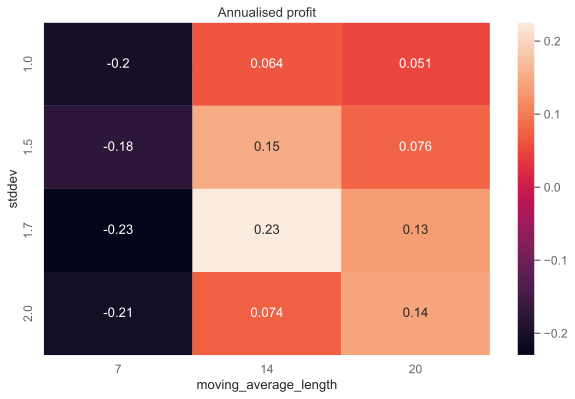

In [10]:
from tradeexecutor.analysis.grid_search import visualise_heatmap_2d

# Remove one extra axis by focusing only rsi_threshold=65
heatmap_data = table.xs(65, level="rsi_threshold")

# Draw heatmaps for two different metrics
visualise_heatmap_2d(heatmap_data, "stddev", "moving_average_length", "Annualised profit")

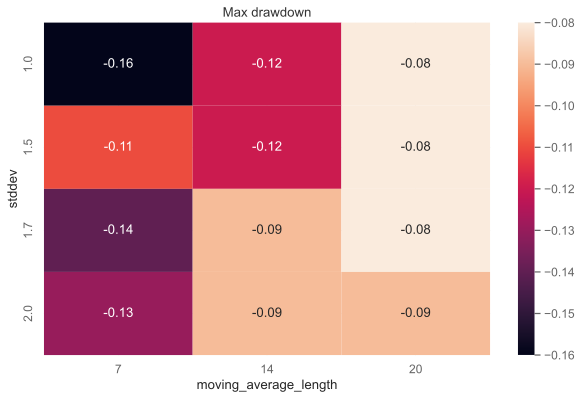

In [11]:
# Draw another heatmap
visualise_heatmap_2d(heatmap_data, "stddev", "moving_average_length", "Max drawdown")

## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [12]:
print("All ok")

All ok
